# Introduction
In this notebook, we are going to solve a simple optimal growth model with one agent. The model is a simplified version of Brock and Mirman (1972). The planner aims to maximize his time-separable life time utility \eqref{eq:obj} subject to his budget constraint \eqref{eq:const}:
$$
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t} \ln\left(c_{t}\right) \label{eq:obj}\\
\text{s.t.} \quad & k_{t+1} + c_{t} \leq Ak_{t}^\alpha \label{eq:const}
\end{align}
$$
As is well known, this particular problem has an analytical solution:
$$
\begin{align}
k_{t+1} = \beta \alpha A k_{t}^{\alpha} \label{eq:analytic_policy}
\end{align}
$$

The aim of this notebook is to approximate the optimal policy function, given in \eqref{eq:analytic_policy}, by using deep neural net (Azinovic et.al (2019)).

First, we need to import necessary python libraries and tensorflow:

In [15]:
# Import necessary liblaries
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rc

# Use TeX font
rc('font', **{'family': 'sans-serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
plt.rcParams["font.size"] = 15

%matplotlib inline
print("Version of tensorflow is {}".format(tf.__version__))

Version of tensorflow is 1.13.1


We define the following economic parameters:

In [16]:
A = 1  # Technology level
alpha = 0.35  # Capital share in the Cobb-Douglas production function
beta = 0.98  # Discount factor

As mentioned, the optimal growth model has a closed form solution and based on this, we can compute the stationary point (or steady state) as well as the optimal consumption policy:

In [17]:
def k_compute_infty(alpha, beta, A):
    """ Return the stationary point (or steady state) """
    return (1 / (beta * alpha * A))**(1/(alpha - 1))


k_infty = k_compute_infty(alpha, beta, A)
print("Stationary point is {:5f}".format(k_infty))


def k_plus_analytic(k, alpha, beta, A):
    """ Analytical solution
    Return the optimal capital stock in the next period """
    return alpha * beta * A * k**alpha


def consum(k, kplus, alpha, beta, A):
    """ Return the optimal consumption policy """
    return A*k**alpha - kplus

Stationary point is 0.192783


# Deep neural net
## Hyper parameters

Hyper parameter defines the architecture of deep neural net. Following Azinovic et al. (2019), we adopt the following hyper parameters:  
Layer 1: the input layer, 1 neuron corresponding to the capital stock today  
Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
Layer 4: the output layer, 2 neurons corresponding to the capital stock tomorrow and the Lagrange multiplier

In [18]:
# Layer setting
num_input = 1
num_hidden1 = 100
num_hidden2 = 100
num_output = 2
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

learning_rate = 0.001  # Leargning rate
t_length = 10000  # Simulation length

# Number of episodes, epochs and minibatch size
num_episodes = 50
num_epochs = 10
minibatch_size = 64

Dimensions of each layer are [1, 100, 100, 2]


## Utility functions
We define some utility functions, which facilitate our subsequent implementations:

In [19]:
def create_placeholders(num_x):
    """ Create the placeholders.
    The column dimention is None that represents the length of the simulated
    path."""
    X = tf.placeholder(tf.float32, shape=[num_x, None], name='X')
    return X


def initialize_parameters(layers_dim):
    """ Initialize parameters to build a neural network
    1: [num_input, None] -> [num_hidden1, None]
    2: [num_hidden1, None] -> [num_hidden2, None]
    3: [num_hidden2, None] -> [num_output, None] """

    W1 = tf.get_variable('W1', [layers_dim[1], layers_dim[0]], tf.float32,
                         tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [layers_dim[1], 1], tf.float32,
                         tf.zeros_initializer())
    W2 = tf.get_variable('W2', [layers_dim[2], layers_dim[1]], tf.float32,
                         tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [layers_dim[2], 1], tf.float32,
                         tf.zeros_initializer())
    W3 = tf.get_variable('W3', [layers_dim[3], layers_dim[2]], tf.float32,
                         tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [layers_dim[3], 1], tf.float32,
                         tf.zeros_initializer())

    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return parameters


def forward_propagation(X, parameters):
    """ Implement the forward propagation for the model
    Linear -> Relu -> Linear -> Relu -> Linear -> Softplus """

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1, X), b1)  # Linear combination
    A1 = tf.nn.relu(Z1)  # Activate with Relu
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Linear combination
    A2 = tf.nn.relu(Z2)  # Activate with Relu
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Linear combination
    A3 = tf.nn.softplus(Z3)  # Activate with Relu

    return A3

## Mini-batches
We use the mini-batch gradient descent to get a gradient update at a lower computational cost. We randomly divide the training data into some subsets, which are refer to as a mini-batch. In each epoch, all of training data points are allocated to a mini-batch and are visited exactly one time:

In [20]:
def random_mini_batches_X(X, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're
    "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[1]  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle X
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]

    # Step 2: Partition shuffled_X. Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size:k * mini_batch_size +
                                  mini_batch_size]
        mini_batch = (mini_batch_X)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches *
                                  mini_batch_size:m]
        mini_batch = (mini_batch_X)
        mini_batches.append(mini_batch)

    return mini_batches

## Cost function

Now we aim to solve the Brock and Mirman (1972) by using deep learning following Azinovic et al. (2019). When we solve the above model for the first-order condition, we can derive the following two equilibrium conditions. Cost function is the mean squared sum of the relative Euler error and the approximation error in the KKT condition:
$$
\begin{align}
& \lambda_{t} - \beta \lambda_{t+1} A \alpha k_{t+1}^{\alpha - 1} = 0 \label{eq:REE}\\
& \left[A k_{t}^{\alpha} - k_{t+1} - \frac{1}{\lambda_{t}}\right]\lambda_{t} = 0 \label{eq:KKT}
\end{align}
$$

In [21]:
def compute_cost(X, A3, parameters, beta, A, alpha):
    """ Compute the mean squared error
    errREE: relative Euler error
    errKKT: error in the KKT complementarity equation """

    # Retlieve the current capital state
    k = X

    # Retlieve the simulation path
    # Need to have a dimension of [num_x, None] to have compativility with the
    # placeholder X
    k_plus = tf.expand_dims(A3[0, :], axis=0)
    lambd = tf.expand_dims(A3[1, :], axis=0)

    # Retlieve the optimal actions in the next period
    action_plus = forward_propagation(k_plus, parameters)
    # Need to have a dimension of [num_x, None] to have compativility with the
    # placeholder X
    k_plusplus = tf.expand_dims(action_plus[0, :], axis=0)
    lambd_plus = tf.expand_dims(action_plus[1, :], axis=0)

    # Define the relative Euler error
    errREE = (beta * lambd_plus * A * alpha * k_plus**(alpha-1)) / lambd - 1

    # Define the KKT error
    errKKT = lambd * (A * k**alpha - k_plus - 1/lambd)

    # Stack two approximation errors
    err = tf.stack([errREE[0], errKKT[0]])

    # When the two constraints are exactly binding
    err_optimal = tf.zeros_like(err)

    # Define the cost function
    cost = tf.losses.mean_squared_error(err, err_optimal)

    return cost


## Define the model with the given training data

In this section, we define the model where we train the deep neural net with the give training data points.

In [25]:
def model(train_X, layers_dim, learning_rate, num_epochs, minibatch_size,
          print_span, print_cost=True):
    """ Train DNN with the provided training data """

    tf.reset_default_graph()  # Reset DNN
    (num_input, t_length) = train_X.shape
    costs = []  # Keep track of the cost

    # Create placeholder
    X = create_placeholders(num_input)
    # Initialize parameters
    parameters = initialize_parameters(layers_dim)
    # One step of the forward propagation
    A3 = forward_propagation(X, parameters)
    # Compute the current cost
    cost = compute_cost(X, A3, parameters, beta, A, alpha)
    # Set the optimizer in the backward propagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        cost)
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # ----------------------------------------------------------------------- #
    # Start to train DNN with random minibatches
    # ----------------------------------------------------------------------- #
    with tf.Session() as sess:
        sess.run(init)  # Initialization

        for epoch in range(1, num_epochs+1):
            epoch_cost = 0  # Initialize and track the cost for each epoch
            # Number of minibatch size
            num_minibatches = int(t_length / minibatch_size)
            minibatches = random_mini_batches_X(train_X, minibatch_size)

            for minibatch in minibatches:
                minibatch_X = minibatch
                _, minibatch_cost = sess.run(
                    [optimizer, cost], feed_dict={X: minibatch_X})
                epoch_cost += minibatch_cost / num_minibatches

            # Track the cost
            costs.append(epoch_cost)

            # Print the cost every epoch
            if print_cost is True and epoch % print_span == 0:
                print(r'Cost after iteration {} is {:.3e}'.format(
                    epoch, epoch_cost))

        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained")

        return costs, parameters

Training data is

In [26]:
kbeg, kend, ksize = 1e-6, 0.25, 250
kinit = (kbeg + kend) / 2
kgrid = np.linspace(kbeg, kend, ksize, dtype=np.float32)
train_X = np.random.uniform(kbeg, kend, (num_input, t_length))
print("train_X has a shape of {}".format(train_X.shape))

train_X has a shape of (1, 10000)


Cost after iteration 50 is 1.157e-03
Cost after iteration 100 is 4.441e-04
Cost after iteration 150 is 2.730e-04
Cost after iteration 200 is 1.926e-04
Cost after iteration 250 is 1.714e-04
Cost after iteration 300 is 1.749e-04
Cost after iteration 350 is 1.677e-04
Cost after iteration 400 is 1.529e-04
Cost after iteration 450 is 1.604e-04
Cost after iteration 500 is 1.627e-04
Cost after iteration 550 is 1.805e-04
Cost after iteration 600 is 1.717e-04
Cost after iteration 650 is 1.487e-04
Cost after iteration 700 is 1.498e-04
Cost after iteration 750 is 1.327e-04
Cost after iteration 800 is 1.249e-04
Cost after iteration 850 is 1.251e-04
Cost after iteration 900 is 1.098e-04
Cost after iteration 950 is 1.016e-04
Cost after iteration 1000 is 9.878e-05
Parameters have been trained


(0, 1048.95)

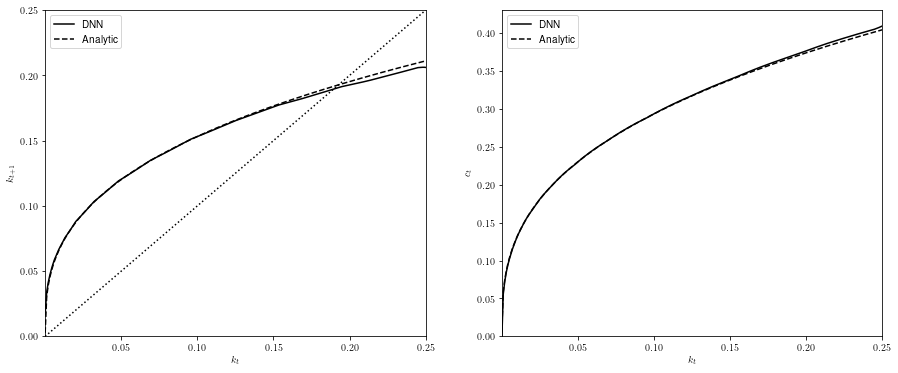

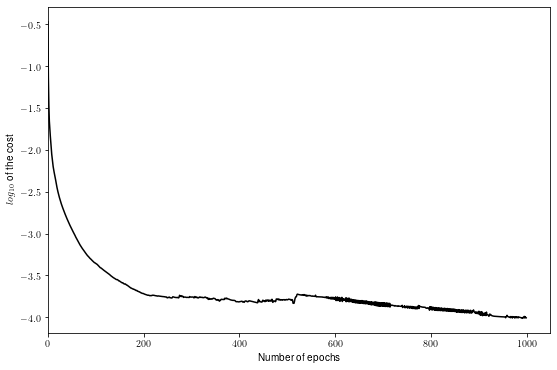

In [27]:
costs, parameters_star = model(
    train_X, layers_dim, learning_rate, num_epochs=1000,
    minibatch_size=minibatch_size, print_span=50, print_cost=True)

with tf.Session() as sess:
    # One step of the forward propagation
    policy_star = sess.run(forward_propagation(
        kgrid.reshape(1, ksize), parameters_star))

# Capital stock in the next period
k_plus_analytic_path = k_plus_analytic(kgrid, alpha, beta, A)
# Consumption policy
c_analytic = consum(kgrid, k_plus_analytic_path, alpha, beta, A)
c_dnn = consum(kgrid, policy_star[0, :], alpha, beta, A)

# Capital stock tomorrow
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axes[0].plot(kgrid, policy_star[0, :], 'k-', label="DNN")
axes[0].plot(kgrid, k_plus_analytic_path, 'k--', label="Analytic")
axes[0].plot(kgrid, kgrid, 'k:')
axes[0].set_xlabel(r"$k_{t}$")
axes[0].set_ylabel(r"$k_{t+1}$")
axes[0].set_xlim([kbeg, kend])
axes[0].set_ylim([0, kend])
axes[0].legend(loc='best')

axes[1].plot(kgrid, c_dnn, 'k-', label="DNN")
axes[1].plot(kgrid, c_analytic, 'k--', label="Analytic")
axes[1].set_xlabel(r"$k_{t}$")
axes[1].set_ylabel(r"$c_{t}$")
axes[1].set_xlim([kbeg, kend])
axes[1].set_ylim([0, None])
axes[1].legend(loc='best')

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(np.log10(costs), 'k-')
ax.set_xlabel("Number of epochs")
ax.set_ylabel("$log_{10}$ of the cost")
ax.set_xlim([0, None])

As seen above, deep neural net successfully approximates the policy functions. The cost function decreases as the training proceeds and converges at approximately $10^{-4}$.

## Deep neural net with sampling the most relevant states

In the previous example, we train the model with the fixed training data that, we hope, efficiently covers the ergodic set. In this example, in every episode, we simulate the training data points with the given initial state and updated parameters (Azinovic et al. (2019)).

In [30]:
def model_sampling(
        init_state, num_input, t_length, layers_dim, learning_rate,
        num_episodes, num_epochs, minibatch_size, print_span, print_cost=True):
    """ Train DNN with sampling the most relevant states """

    tf.reset_default_graph()  # Reset DNN

    costs = []  # Keep track of the cost

    episodic_costs = []  # Keep track of the episodic cost

    # Create placeholder
    X = create_placeholders(num_input)
    # Initialize parameters
    parameters = initialize_parameters(layers_dim)
    # One step of the forward propagation
    A3 = forward_propagation(X, parameters)
    # Compute the current cost
    cost = compute_cost(X, A3, parameters, beta, A, alpha)
    # Set the optimizer in the backward propagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        cost)
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # ----------------------------------------------------------------------- #
    # Start to train DNN with sampling and random minibatches
    # ----------------------------------------------------------------------- #
    with tf.Session() as sess:
        sess.run(init)  # Initialization

        for episode in range(1, num_episodes+1):
            episodic_cost = 0
            # --------------------------------------------------------------- #
            # Simulate one training path
            # --------------------------------------------------------------- #
            # Training set, which samples the most relevent states
            # Keep compativility with placeholder X that has [num_input. None]
            train_X = np.empty((num_input, t_length), dtype=np.float32)
            # Retlieve the initial state from the previous episode
            train_X[0, 0] = init_state
            for t in range(1, t_length):
                # Keep the same shape with X ([num_input, None])
                x_previous = train_X[0, t-1].reshape((num_input, 1))
                train_X[0, t] = sess.run(A3, feed_dict={X: x_previous})[0]

            # --------------------------------------------------------------- #
            # Train DNN with the sampled state path
            # --------------------------------------------------------------- #
            for epoch in range(1, num_epochs+1):
                epoch_cost = 0  # Initialize and trach the cost for each epoch
                # Number of minibatch size
                num_minibatches = int(t_length / minibatch_size)
                minibatches = random_mini_batches_X(train_X, minibatch_size)

                for minibatch in minibatches:
                    minibatch_X = minibatch
                    _, minibatch_cost = sess.run(
                        [optimizer, cost], feed_dict={X: minibatch_X})
                    epoch_cost += minibatch_cost / num_minibatches

                # Track the cost
                costs.append(epoch_cost)

                # Print the cost every epoch
                if print_cost is True and epoch % print_span == 0:
                    print(
                        r'Cost after epoch {} in episode {} is {:.3e}'.format(
                            epoch, episode, epoch_cost))
                episodic_cost += epoch_cost / num_epochs
            # Track the episodic cost
            episodic_costs.append(episodic_cost)

            # Trach the last state for the next episode
            init_state = train_X[0, -1]
            train_X_previous = train_X

        # Save the parameters in a variable
        parameters = sess.run(parameters)

        return costs, episodic_costs, parameters, train_X, train_X_previous

Then we train the model with sampling the most relevant state:

Cost after epoch 5 in episode 1 is 3.763e-05
Cost after epoch 10 in episode 1 is 3.752e-05
Cost after epoch 5 in episode 2 is 1.680e-04
Cost after epoch 10 in episode 2 is 1.586e-04
Cost after epoch 5 in episode 3 is 7.361e-06
Cost after epoch 10 in episode 3 is 7.426e-06
Cost after epoch 5 in episode 4 is 5.390e-08
Cost after epoch 10 in episode 4 is 5.545e-08
Cost after epoch 5 in episode 5 is 1.245e-09
Cost after epoch 10 in episode 5 is 1.398e-09
Cost after epoch 5 in episode 6 is 1.142e-11
Cost after epoch 10 in episode 6 is 1.093e-06
Cost after epoch 5 in episode 7 is 2.706e-07
Cost after epoch 10 in episode 7 is 6.432e-07
Cost after epoch 5 in episode 8 is 8.595e-07
Cost after epoch 10 in episode 8 is 9.688e-08
Cost after epoch 5 in episode 9 is 1.144e-06
Cost after epoch 10 in episode 9 is 9.114e-08
Cost after epoch 5 in episode 10 is 9.622e-07
Cost after epoch 10 in episode 10 is 6.408e-07
Cost after epoch 5 in episode 11 is 8.912e-07
Cost after epoch 10 in episode 11 is 1.008

Cost after epoch 10 in episode 89 is 4.761e-07
Cost after epoch 5 in episode 90 is 6.870e-07
Cost after epoch 10 in episode 90 is 1.071e-07
Cost after epoch 5 in episode 91 is 7.623e-07
Cost after epoch 10 in episode 91 is 6.179e-07
Cost after epoch 5 in episode 92 is 5.549e-07
Cost after epoch 10 in episode 92 is 1.915e-07
Cost after epoch 5 in episode 93 is 4.757e-07
Cost after epoch 10 in episode 93 is 8.649e-07
Cost after epoch 5 in episode 94 is 5.192e-07
Cost after epoch 10 in episode 94 is 9.272e-09
Cost after epoch 5 in episode 95 is 4.855e-07
Cost after epoch 10 in episode 95 is 6.049e-07
Cost after epoch 5 in episode 96 is 4.441e-07
Cost after epoch 10 in episode 96 is 1.681e-09
Cost after epoch 5 in episode 97 is 4.618e-08
Cost after epoch 10 in episode 97 is 7.645e-07
Cost after epoch 5 in episode 98 is 5.859e-07
Cost after epoch 10 in episode 98 is 8.813e-07
Cost after epoch 5 in episode 99 is 3.104e-08
Cost after epoch 10 in episode 99 is 5.940e-07
Cost after epoch 5 in e

(0, 103.95)

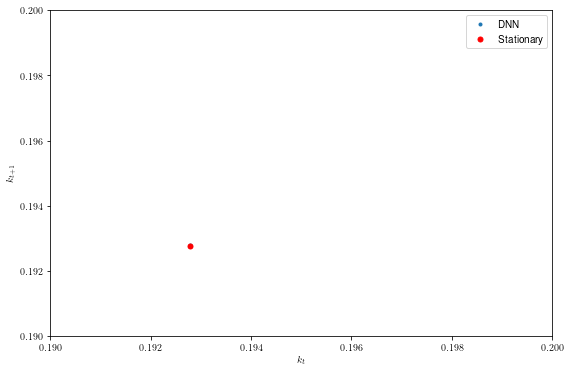

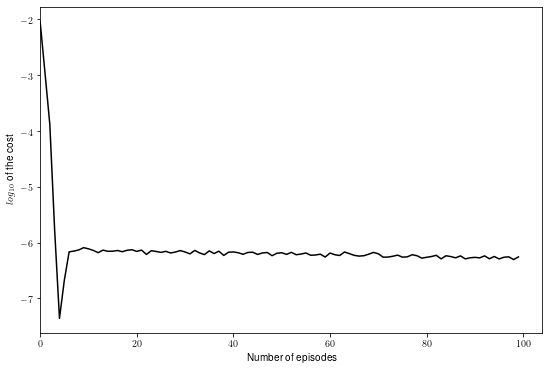

In [31]:
costs_sampling, episodic_costs, parameters_sampling, train_X, \
    train_X_previous = model_sampling(
        kinit, num_input, t_length, layers_dim, learning_rate, num_episodes,
        num_epochs, minibatch_size, print_span=5, print_cost=True)


fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(train_X_previous[0, :], train_X[0, :], 'o', markersize=3, label='DNN')
ax.plot(k_infty, k_infty, 'o', c='red', markersize=5, label='Stationary')
ax.set_xlim([0.19, 0.20])
ax.set_ylim([0.19, 0.20])
ax.set_xlabel(r"$k_{t}$")
ax.set_ylabel(r"$k_{t+1}$")

ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(np.log10(episodic_costs), 'k-')
ax.set_xlabel("Number of episodes")
ax.set_ylabel("$log_{10}$ of the cost")
ax.set_xlim([0, None])

As you might expect, deep neural net approximate policy functions exactly on the stationary point.